## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import seaborn as sns
import shapefile
import warnings
import urllib.request
import zipfile
import random
import itertools
import math
import datetime
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt

## Data processing

In [16]:
df_jan = pd.read_csv("data/yellow_tripdata_2020-01.csv")
months = ["Jan","Feb", "Mar", "Apr", "May", "Jun"]
df_list = {}
for i in range(0,6):
    df_list[months[i]] = pd.read_csv("data/yellow_tripdata_2020-0{}.csv".format(i+1))
    df_list[months[i]][['tpep_pickup_datetime']] = df_list[months[i]][['tpep_pickup_datetime']].astype('datetime64[ns]')
    df_list[months[i]][['tpep_dropoff_datetime']] = df_list[months[i]][['tpep_dropoff_datetime']].astype('datetime64[ns]')
    df_list[months[i]]['duration'] = (df_list[months[i]]['tpep_dropoff_datetime'] - df_list[months[i]]['tpep_pickup_datetime']).astype('timedelta64[s]')/60
    df_list[months[i]] = df_list[months[i]].loc[ df_list[months[i]]["duration"] > 0 ]
    df_list[months[i]]['tip_per_minute'] = df_list[months[i]]['tip_amount']/df_list[months[i]]['duration']

In [17]:
df_list['Jan'].loc[(df_list['Jan']["payment_type"] == 1) & (df_list['Jan']["PULocationID"] == 145), ["tip_amount","tip_per_minute", "duration", "trip_distance"]].corr()

,tip_amount,tip_per_minute,duration,trip_distance
tip_amount,1.000000,0.208747,0.050108,0.245601
tip_per_minute,0.208747,1.000000,-0.027153,-0.075699
duration,0.050108,-0.027153,1.000000,0.116388
trip_distance,0.245601,-0.075699,0.116388,1.000000


In [18]:
df_list["Jan"] = df_list["Jan"].loc[df_list['Jan']["duration"]>0]

In [19]:
len(df_list["Jan"])

6400602

I think start here for legit code

In [20]:
df_array = []    

for i in range(0,6):
    curr_df = pd.read_csv("data/yellow_tripdata_2020-0{}.csv".format(i+1))
    print(len(curr_df))
    curr_df[['tpep_pickup_datetime']] = curr_df[['tpep_pickup_datetime']].astype('datetime64[ns]')
    curr_df[['tpep_dropoff_datetime']] = curr_df[['tpep_dropoff_datetime']].astype('datetime64[ns]')
    curr_df['duration'] = (curr_df['tpep_dropoff_datetime'] - curr_df['tpep_pickup_datetime']).astype('timedelta64[s]')/60
    curr_df = curr_df.loc[(curr_df["duration"] > 0)]
    #might wnana do the code below after group by
    #curr_df = curr_df.loc[(curr_df["tpep_pickup_datetime"] >= datetime.datetime(2020,1,1))&(curr_df[['tpep_dropoff_datetime']] <  datetime.datetime(2020,7,1))]
    curr_df['tip_per_minute'] = curr_df['tip_amount']/curr_df['duration']
    df_array.append(curr_df)

6405008
6299354
3007292
237993
348371
549760


In [21]:
final_df = pd.concat(df_array)
#final_df = final_df.loc[(final_df["tpep_pickup_datetime"] >= datetime.datetime(2020,1,1))& (final_df[['tpep_dropoff_datetime']] <  datetime.datetime(2020,7,1))]

#final_df.to_csv("First Half 2020 NYC Yellow Taxi Dataset")    
final_df.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
duration                        float64
tip_per_minute                  float64
dtype: object

This is thought process of group by date every day, thinking of every hour and average or median

In [22]:
new_df = final_df.copy()
new_df["tpep_pickup_datetime"] = new_df["tpep_pickup_datetime"].astype("datetime64[D]")
group_by_date = new_df.groupby(["tpep_pickup_datetime"], as_index=False).agg("count")
group_by_date = group_by_date[["tpep_pickup_datetime", "fare_amount"]].loc[(group_by_date["tpep_pickup_datetime"] >= datetime.datetime(2020,1,1)) & (group_by_date["tpep_pickup_datetime"] < datetime.datetime(2020,7,1))]
print(group_by_date)

    tpep_pickup_datetime  fare_amount
5             2020-01-01       169314
6             2020-01-02       162024
7             2020-01-03       183355
8             2020-01-04       182637
9             2020-01-05       164278
..                   ...          ...
182           2020-06-26        26201
183           2020-06-27        17199
184           2020-06-28        15188
185           2020-06-29        24815
186           2020-06-30        25123

[182 rows x 2 columns]


Covid Cases:

In [23]:
covid_case = pd.read_csv("data/us-states.csv")
covid_case_nyc_temp = covid_case.loc[covid_case["state"] == "New York"]
covid_case_nyc_temp["date"] = pd.to_datetime(covid_case_nyc_temp["date"], format='%Y-%m-%d')

temp = [0]

for i in covid_case_nyc_temp["cases"]:
    temp.append(i)
new_temp = []
for i in range(1, len(temp)):
    new_temp.append(temp[i] - temp[i-1])
covid_case_nyc_temp["daily change"] = new_temp

covid_data_dict = {"date": [], "cases": [], "deaths": [], "daily change":[]}

init_date = datetime.datetime(2020,1,1)
while init_date < datetime.datetime(2020,3,1):
    covid_data_dict["date"].append(init_date)
    covid_data_dict["cases"].append(0)
    covid_data_dict["deaths"].append(0)
    covid_data_dict["daily change"].append(0)
    init_date += datetime.timedelta(days=1)

new_covid_case_nyc = pd.DataFrame(data = covid_data_dict)
covid_case_nyc_temp
covid_case_nyc = pd.concat([new_covid_case_nyc, covid_case_nyc_temp[["date","cases", "deaths", "daily change"]]]).reset_index(drop = True)
covid_case_nyc


,date,cases,deaths,daily change
0,2020-01-01,0,0,0
1,2020-01-02,0,0,0
2,2020-01-03,0,0,0
3,2020-01-04,0,0,0
4,2020-01-05,0,0,0
...,...,...,...,...
236,2020-08-24,434866,32489,404
237,2020-08-25,435495,32495,629
238,2020-08-26,436063,32499,568
239,2020-08-27,436852,32507,789


Percipitation level

In [24]:
percipitation = pd.read_csv("data/Percipitation past 6 months.csv", sep = ";")
percipitation = percipitation.drop(percipitation.index[182])
percipitation["Date"] = pd.to_datetime(percipitation['Date'], format='%d/%m/%y')
print(percipitation["Percipitation (in)"].describe())
percipitation

count    182.000000
mean       0.080165
std        0.195444
min        0.000000
25%        0.000000
50%        0.000000
75%        0.040000
max        1.120000
Name: Percipitation (in), dtype: float64


,Date,Percipitation (in)
0,2020-01-01,0.00
1,2020-01-02,0.00
2,2020-01-03,0.01
3,2020-01-04,0.00
4,2020-01-05,0.01
...,...,...
177,2020-06-26,0.00
178,2020-06-27,0.00
179,2020-06-28,0.10
180,2020-06-29,0.00


Plot:

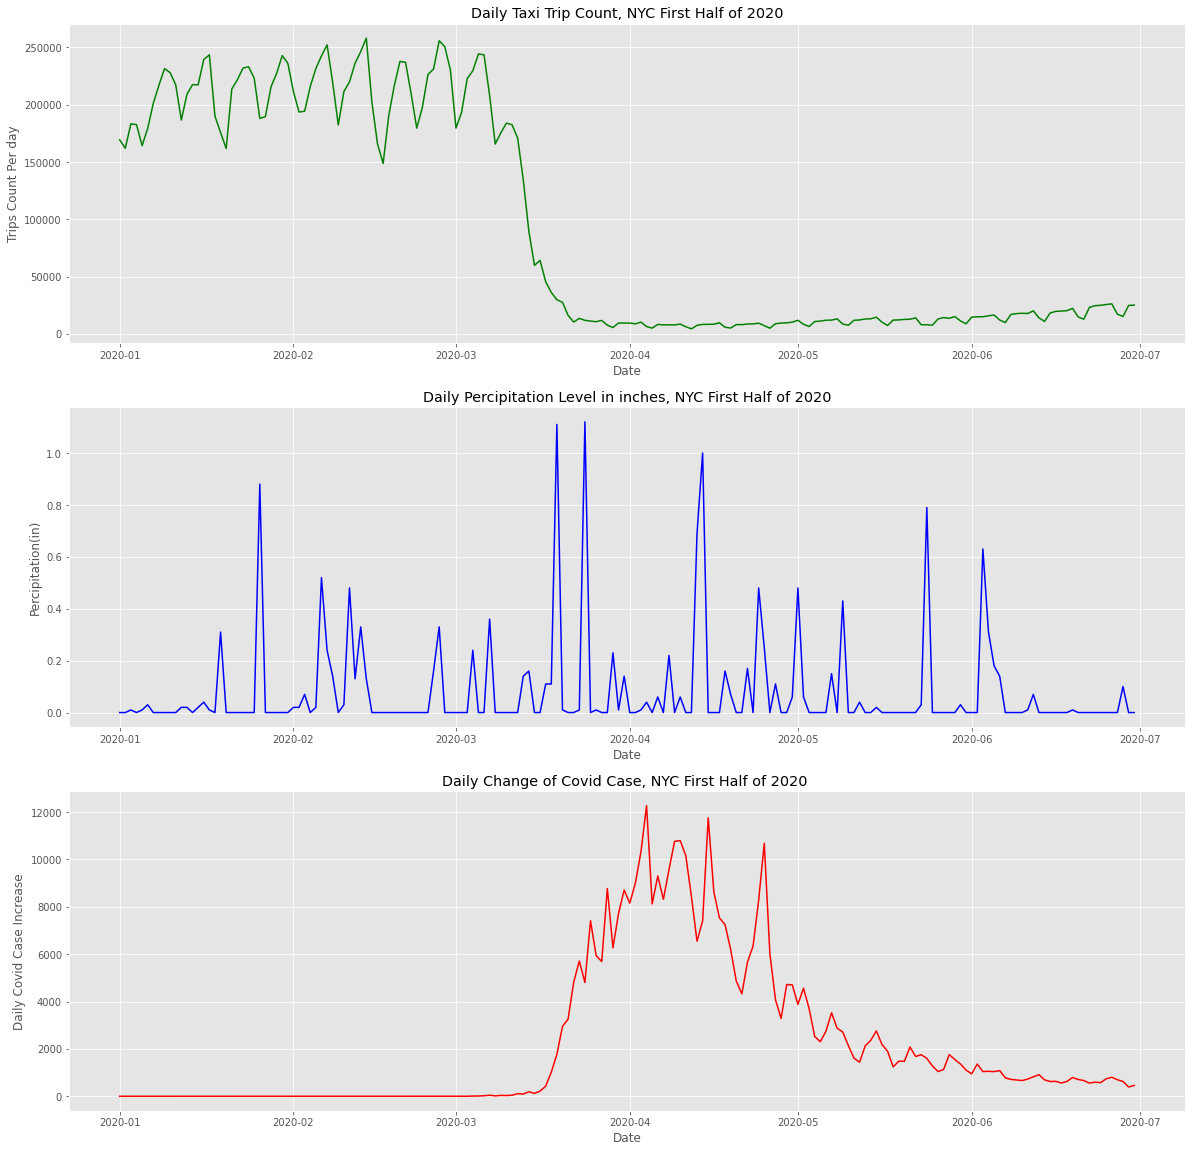

In [25]:
plot_data = percipitation.loc[percipitation["Date"] < datetime.datetime(2020,7,1)]
#merge new dataframe with daily changes 0 from january

covid_data = covid_case_nyc.loc[covid_case_nyc["date"] < datetime.datetime(2020,7,1)]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 20), nrows = 3)

ax1.plot(group_by_date['tpep_pickup_datetime'],
        group_by_date['fare_amount'],
        color='green')

ax1.set(xlabel="Date",
       ylabel="Trips Count Per day",
       title="Daily Taxi Trip Count, NYC First Half of 2020")

ax2.plot(plot_data['Date'],
       plot_data['Percipitation (in)'],
       color='blue')
ax2.set(xlabel="Date",
       ylabel="Percipitation(in)",
       title="Daily Percipitation Level in inches, NYC First Half of 2020")
ax3.plot(covid_data['date'],
       covid_data['daily change'],
       color='red')
ax3.set(xlabel="Date",
       ylabel="Daily Covid Case Increase",
       title="Daily Change of Covid Case, NYC First Half of 2020 ")

plt.savefig("plots/Trip Count, Percipitation, and Covid Case Line graph.png")
plt.show()

Correlation

In [26]:
#showing the bias of 2020 data
temp_df = group_by_date[["tpep_pickup_datetime", "fare_amount"]].reset_index(drop = True).copy()
temp_df["Percipitation level"] = percipitation["Percipitation (in)"].copy()
temp_df["Covid Daily Change"] = covid_data["daily change"].copy()

temp_df.corr()

,fare_amount,Percipitation level,Covid Daily Change
fare_amount,1.000000,-0.053157,-0.595026
Percipitation level,-0.053157,1.000000,0.099795
Covid Daily Change,-0.595026,0.099795,1.000000


In [36]:
new_df = final_df.copy()
new_df["tpep_pickup_datetime"] = new_df["tpep_pickup_datetime"].astype("datetime64[D]")

group_by_date = new_df.groupby(["tpep_pickup_datetime"], as_index=False).agg("median")
group_by_date = group_by_date.loc[(group_by_date["tpep_pickup_datetime"] >= datetime.datetime(2020,1,1)) & (group_by_date["tpep_pickup_datetime"] < datetime.datetime(2020,7,1))]

print(group_by_date)
group_by_date = new_df.groupby(["tpep_pickup_datetime"], as_index=False).agg("count")
group_by_date = group_by_date[["tpep_pickup_datetime", "fare_amount"]].loc[(group_by_date["tpep_pickup_datetime"] >= datetime.datetime(2020,1,1)) & (group_by_date["tpep_pickup_datetime"] < datetime.datetime(2020,7,1))]


    tpep_pickup_datetime  VendorID  passenger_count  trip_distance  \
5             2020-01-01       2.0              1.0          1.905   
6             2020-01-02       2.0              1.0          1.690   
7             2020-01-03       2.0              1.0          1.600   
8             2020-01-04       2.0              1.0          1.640   
9             2020-01-05       2.0              1.0          1.700   
..                   ...       ...              ...            ...   
182           2020-06-26       2.0              1.0          1.800   
183           2020-06-27       2.0              1.0          1.900   
184           2020-06-28       2.0              1.0          2.000   
185           2020-06-29       2.0              1.0          1.800   
186           2020-06-30       2.0              1.0          1.780   

     RatecodeID  PULocationID  DOLocationID  payment_type  fare_amount  extra  \
5           1.0         158.0         158.0           1.0          9.5    0.5 

Divide into covid period and non covid period. First reported case 2020-03-01 (following the dataset). Divide into before and after period. 
#Note: This is ETL set of code specifically to be merged and group by.

In [43]:
precovid_nyc_taxi = final_df.loc[(final_df["tpep_pickup_datetime"] <  datetime.datetime(2020,3,1)) & (final_df["tpep_pickup_datetime"] >=  datetime.datetime(2020,1,1))].reset_index(drop = True)
precovid_nyc_taxi["tpep_pickup_datetime"] = precovid_nyc_taxi["tpep_pickup_datetime"].astype("datetime64[D]")
precovid_nyc_taxi = pd.merge(precovid_nyc_taxi, percipitation, how = "left", left_on = "tpep_pickup_datetime", right_on = "Date")
precovid_nyc_taxi.dtypes

postcovid_nyc_taxi = final_df.loc[(final_df["tpep_pickup_datetime"] >=  datetime.datetime(2020,3,1)) & (final_df["tpep_pickup_datetime"] <  datetime.datetime(2020,7,1))].reset_index(drop = True)
postcovid_nyc_taxi["tpep_pickup_datetime"] = postcovid_nyc_taxi["tpep_pickup_datetime"].astype("datetime64[D]")
postcovid_nyc_taxi = pd.merge(postcovid_nyc_taxi, percipitation, how = "left", left_on = "tpep_pickup_datetime", right_on = "Date")

precovid_nyc_taxi.loc[(precovid_nyc_taxi["Percipitation (in)"] > 0.1) & (precovid_nyc_taxi["payment_type"] == 1) & (precovid_nyc_taxi["PULocationID"] == 84)].describe()

nyc_taxi = final_df.copy()
nyc_taxi["tpep_pickup_datetime_D"] = nyc_taxi["tpep_pickup_datetime"].astype("datetime64[D]")
nyc_taxi = pd.merge(nyc_taxi, percipitation, how = "left", left_on = "tpep_pickup_datetime_D", right_on = "Date")
nyc_taxi = pd.merge(nyc_taxi, covid_data, how = "left", left_on = "tpep_pickup_datetime_D", right_on = "date")
nyc_taxi = nyc_taxi.loc[nyc_taxi["payment_type"] == 1]


In [45]:
nyc_taxi.to_csv("taxidata_covid_percipitation.csv")

In [438]:
precovid_group_date =  precovid_nyc_taxi.loc[(precovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")
postcovid_group_date = postcovid_nyc_taxi.loc[(postcovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")


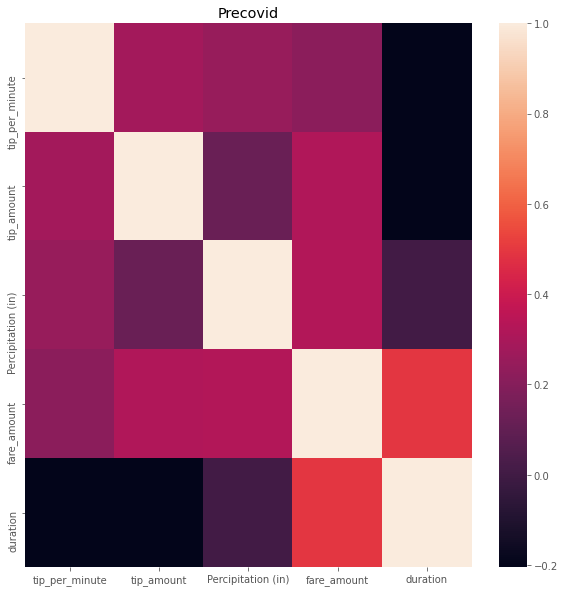

In [454]:
fig , ax = plt.subplots(figsize = (10,10))
sns.heatmap(precovid_group_date[["tip_per_minute","tip_amount", "Percipitation (in)", "fare_amount", "duration"]].corr())
ax.set(title = "Precovid")
plt.savefig("plots/Precovid Correlation.png")

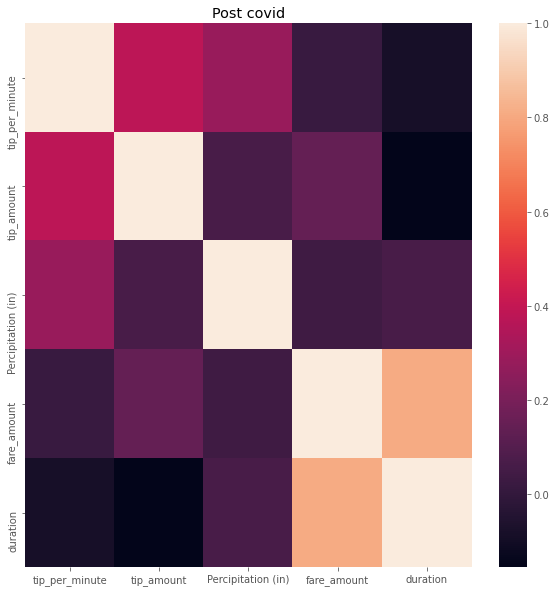

In [453]:
fig , ax = plt.subplots(figsize = (10,10))
sns.heatmap(postcovid_group_date[["tip_per_minute", "tip_amount","Percipitation (in)", "fare_amount", "duration"]].corr())
ax.set(title = "Post covid")
plt.savefig("plots/Postcovid Correlation.png")


Tips analysis

In [286]:
precovid_rain_group_zone = precovid_nyc_taxi.loc[(precovid_nyc_taxi["Percipitation (in)"] > 0.1) & (precovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
precovid_notrain_group_zone = precovid_nyc_taxi.loc[(precovid_nyc_taxi["Percipitation (in)"] <= 0.1) & (precovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
postcovid_rain_group_zone = postcovid_nyc_taxi.loc[(postcovid_nyc_taxi["Percipitation (in)"] > 0.1) & (postcovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
postcovid_notrain_group_zone = postcovid_nyc_taxi.loc[(postcovid_nyc_taxi["Percipitation (in)"] <= 0.1) & (postcovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration,tip_per_minute,Date,Percipitation (in)
3636760,1.0,2020-01-19,2020-01-19 09:55:16,1.0,0.00,1.0,N,81,116,1.0,...,0.5,0.0,0.00,0.3,31.00,0.0,29.066667,0.0,2020-01-19,0.31
5170400,1.0,2020-01-26,2020-01-26 17:43:47,1.0,0.00,1.0,N,81,189,1.0,...,0.5,0.0,12.24,0.3,62.24,0.0,66.616667,0.0,2020-01-26,0.88
5209077,1.0,2020-01-26,2020-01-26 21:10:15,1.0,0.00,1.0,N,81,75,1.0,...,0.5,0.0,0.00,0.3,33.00,0.0,49.066667,0.0,2020-01-26,0.88
7452853,1.0,2020-02-06,2020-02-06 06:59:11,1.0,0.00,1.0,N,81,88,1.0,...,0.5,0.0,6.12,0.3,53.12,0.0,47.966667,0.0,2020-02-06,0.52
7454557,2.0,2020-02-06,2020-02-06 06:38:44,2.0,20.00,1.0,N,81,209,1.0,...,0.5,0.0,6.12,0.3,60.92,0.0,40.183333,0.0,2020-02-06,0.52
7526049,2.0,2020-02-06,2020-02-06 13:20:07,1.0,18.73,1.0,N,81,164,1.0,...,0.5,0.0,6.12,0.3,64.92,0.0,53.450000,0.0,2020-02-06,0.52
7699657,2.0,2020-02-07,2020-02-07 06:44:00,1.0,20.14,1.0,N,81,209,1.0,...,0.5,0.0,6.12,0.3,60.42,0.0,38.716667,0.0,2020-02-07,0.24
7722287,1.0,2020-02-07,2020-02-07 09:20:27,1.0,0.00,1.0,N,81,87,1.0,...,0.5,0.0,6.12,0.3,53.12,0.0,76.483333,0.0,2020-02-07,0.24
7752629,2.0,2020-02-07,2020-02-07 12:11:52,1.0,14.59,1.0,N,81,130,1.0,...,0.5,0.0,6.12,0.3,50.42,0.0,33.583333,0.0,2020-02-07,0.24
8114041,1.0,2020-02-08,2020-02-08 21:30:14,1.0,0.00,1.0,N,81,130,1.0,...,0.5,0.0,6.12,0.3,46.12,0.0,23.350000,0.0,2020-02-08,0.14


## Geo plot attempt

In [396]:
import folium
from folium.plugins import FastMarkerCluster
from folium.features import DivIcon

In [397]:
sf = gpd.read_file("data/taxi_zones/taxi_zones.shp")
sf2 = gpd.read_file("data/nyc_bound/geo_export_9a4e6a5d-0bc6-49c0-9f7b-57add087f4b1.shp")
zone = pd.read_csv("data/taxi_zones/taxi+_zone_lookup.csv")

In [398]:
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [406]:
zone

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


[Text(0.5, 1.0, 'duration distribution')]

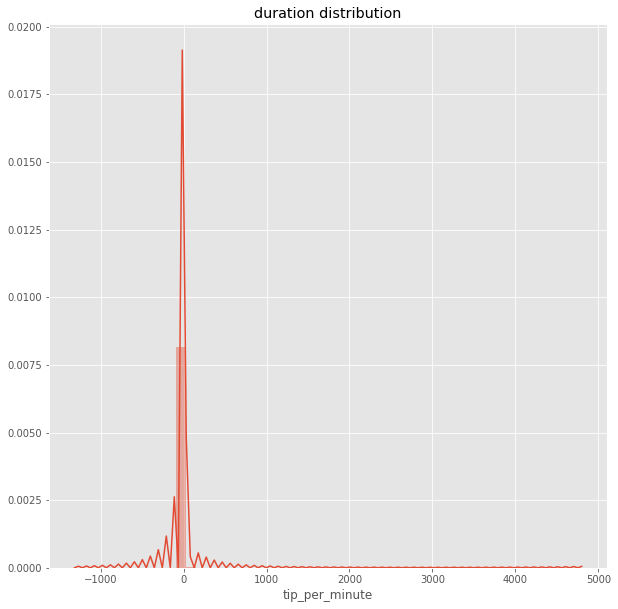

In [472]:
fig , ax = plt.subplots(figsize = (10,10))
sns.distplot(final_df["tip_per_minute"].loc[(final_df["duration"] < 60)])
ax.set(title = "duration distribution")
# plt.savefig("plots/duration distribution.png")

In [399]:
gdf = gpd.GeoDataFrame(pd.merge(final_df , sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
#gdf2 = gpd.GeoDataFrame(sf2)

In [400]:
geoJSON = gdf[['LocationID','geometry']].drop_duplicates('LocationID').to_json()
sf['centeroid'] = sf.centroid

In [415]:
m1 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

bins = list(precovid_rain_group_zone['tip_per_minute'].quantile([0, 0.25, 0.5, 0.75, 1]))

# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name ='choropleth',
    data =  precovid_rain_group_zone,
    columns=['PULocationID', 'tip_per_minute'],
    key_on = 'feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins = bins,
    reset=True
).add_to(m1)


index = 0
for i, row in precovid_rain_group_zone.sort_values(by = "tip_per_minute", ascending = False).head(10).iterrows():
    
    print(zone.loc[zone["LocationID"] == int(row["PULocationID"])]["Zone"].values)
    if(len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x)!= 0 or len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y) != 0):
        x = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x[0]
        y = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y[0]
        
        folium.Marker([y,x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html='<div style="font-size: 18pt; color : black">'+ str(index+1) +'</div>',
        )).add_to(m1)
        m1.add_child(folium.CircleMarker([y,x], radius=15))
        index += 1
m1.save('plots/median tip rate in rain condition before covid.html')


precovid_rain_group_zone["tip_per_minute"].describe()


["Eltingville/Annadale/Prince's Bay"]
['Corona']
['Stapleton']
['Newark Airport']
['Oakwood']
[nan]
['Astoria Park']
['Randalls Island']
['Willets Point']
['South Ozone Park']


count    253.000000
mean       1.929696
std       15.762405
min        0.000000
25%        0.000000
50%        0.163746
75%        0.224044
max      217.700000
Name: tip_per_minute, dtype: float64

In [416]:
m2 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

bins = list(postcovid_rain_group_zone['tip_per_minute'].quantile([0, 0.25, 0.5, 0.75, 1]))

# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name ='choropleth',
    data =  postcovid_rain_group_zone,
    columns=['PULocationID', 'tip_per_minute'],
    key_on = 'feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins = bins,
    reset=True
).add_to(m2)


index = 0
for i, row in postcovid_rain_group_zone.sort_values(by = "tip_per_minute", ascending = False).head(10).iterrows():
    print(zone.loc[zone["LocationID"] == int(row["PULocationID"])]["Zone"].values)
    if(len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x)!= 0 or len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y) != 0):
        x = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x[0]
        y = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y[0]
        
        folium.Marker([y,x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html='<div style="font-size: 18pt; color : black">'+ str(index+1) +'</div>',
        )).add_to(m2)
        m2.add_child(folium.CircleMarker([y,x], radius=15))

        index += 1
m2.save('plots/median tip rate in rain condition after covid.html')

postcovid_rain_group_zone["tip_per_minute"].describe()


['Breezy Point/Fort Tilden/Riis Beach']
['Newark Airport']
['Forest Park/Highland Park']
['Broad Channel']
['Marine Park/Floyd Bennett Field']
[nan]
['Willets Point']
['New Dorp/Midland Beach']
['Astoria Park']
['Flushing Meadows-Corona Park']


count    253.000000
mean       1.240353
std       15.254065
min        0.000000
25%        0.000000
50%        0.097844
75%        0.236409
max      240.000000
Name: tip_per_minute, dtype: float64

In [417]:
m3 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

bins = list(precovid_notrain_group_zone['tip_per_minute'].quantile([0, 0.25, 0.5, 0.75, 1]))

# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name ='choropleth',
    data =  precovid_notrain_group_zone,
    columns=['PULocationID', 'tip_per_minute'],
    key_on = 'feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins = bins,
    reset=True
).add_to(m3)


index = 0
for i, row in precovid_notrain_group_zone.sort_values(by = "tip_per_minute", ascending = False).head(10).iterrows():
    print(zone.loc[zone["LocationID"] == int(row["PULocationID"])]["Zone"].values)

    if(len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x)!= 0 or len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y) != 0):
        x = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x[0]
        y = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y[0]
        
        folium.Marker([y,x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html='<div style="font-size: 18pt; color : black">'+ str(index+1) +'</div>',
        )).add_to(m3)
        m3.add_child(folium.CircleMarker([y,x], radius=15))
        
        index += 1
m3.save('plots/median tip rate in no rain condition before covid.html') 
precovid_notrain_group_zone["tip_per_minute"].describe()
    
      

['New Dorp/Midland Beach']
['Newark Airport']
['Corona']
[nan]
['Stapleton']
['Freshkills Park']
['Astoria Park']
['Randalls Island']
['Maspeth']
['West Brighton']


count    260.000000
mean       0.766591
std        5.780091
min        0.000000
25%        0.000000
50%        0.151211
75%        0.232978
max       75.000000
Name: tip_per_minute, dtype: float64

In [418]:
m4 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

bins = list(postcovid_notrain_group_zone['tip_per_minute'].quantile([0, 0.25, 0.5, 0.75, 1]))

# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name ='choropleth',
    data =  postcovid_notrain_group_zone,
    columns=['PULocationID', 'tip_per_minute'],
    key_on = 'feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins = bins,
    reset=True
).add_to(m4)


index = 0
for i, row in postcovid_notrain_group_zone.sort_values(by = "tip_per_minute", ascending = False).head(10).iterrows():
    print(zone.loc[zone["LocationID"] == int(row["PULocationID"])]["Zone"].values)
    if(len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x)!= 0 or len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y) != 0):
        x = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x[0]
        y = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y[0]
        
        folium.Marker([y,x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html='<div style="font-size: 18pt; color : black">'+ str(index+1) +'</div>',
        )).add_to(m4)
        m4.add_child(folium.CircleMarker([y,x], radius=15))

        index += 1
m4.save('plots/median tip rate in no rain condition after covid.html')
postcovid_notrain_group_zone["tip_per_minute"].describe()


['Port Richmond']
['Newark Airport']
[nan]
['Astoria Park']
['Flushing Meadows-Corona Park']
['Randalls Island']
['Willets Point']
['Briarwood/Jamaica Hills']
['Breezy Point/Fort Tilden/Riis Beach']
['Corona']


count    260.000000
mean       0.368472
std        2.872650
min        0.000000
25%        0.000000
50%        0.071551
75%        0.228402
max       37.500000
Name: tip_per_minute, dtype: float64

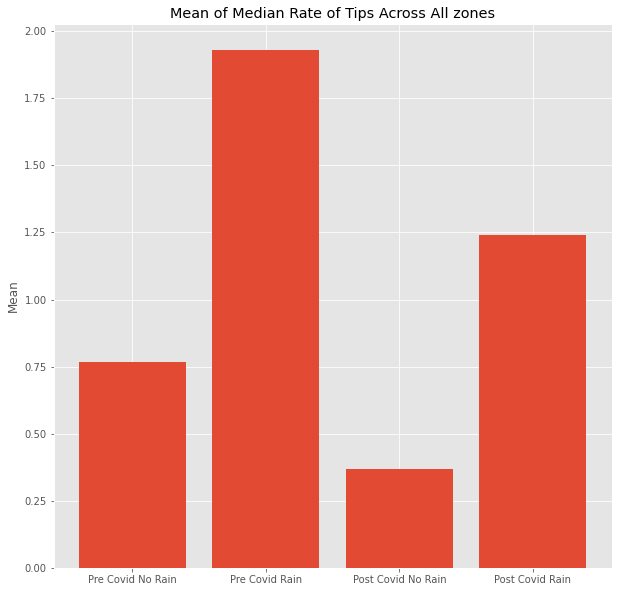

In [432]:
fig2 , ax4 = plt.subplots(figsize = (10,10))
ax4.bar(x = ["Pre Covid No Rain", "Pre Covid Rain", "Post Covid No Rain", "Post Covid Rain"], height = [precovid_notrain_group_zone["tip_per_minute"].describe()["mean"], precovid_rain_group_zone["tip_per_minute"].describe()["mean"], postcovid_notrain_group_zone["tip_per_minute"].describe()["mean"], postcovid_rain_group_zone["tip_per_minute"].describe()["mean"]])
ax4.set(
       ylabel="Mean",
       title="Mean of Median Rate of Tips Across All zones")

plt.savefig("plots/Mean of Median Tips Across All zones.png")
plt.show()

In [ ]:
m5 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

currdf = precovid_nyc_taxi.loc[(precovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("median")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name ='choropleth',
    data =  currdf,
    columns=['PULocationID', 'duration'],
    key_on = 'feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
#     bins = bins,
    reset=True
).add_to(m5)


# index = 0
# for i, row in postcovid_notrain_group_zone.sort_values(by = "tip_per_minute", ascending = False).head(10).iterrows():
#     print(zone.loc[zone["LocationID"] == int(row["PULocationID"])]["Zone"].values)
#     if(len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x)!= 0 or len(sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y) != 0):
#         x = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.x[0]
#         y = sf.loc[sf["LocationID"] == int(row["PULocationID"])]['centeroid'].values.y[0]
        
#         folium.Marker([y,x], icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(7,20),
#         html='<div style="font-size: 18pt; color : black">'+ str(index+1) +'</div>',
#         )).add_to(m4)
#         m4.add_child(folium.CircleMarker([y,x], radius=15))

#         index += 1
m5.save('plots/median duration before covid.html')
m5


In [ ]:
m6 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

currdf = precovid_nyc_taxi.loc[(precovid_nyc_taxi["payment_type"] == 1)].groupby(["DOLocationID"], as_index=False).agg("count")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name ='choropleth',
    data =  currdf,
    columns=['PULocationID', 'fare_amount'],
    key_on = 'feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
#     bins = bins,
    reset=True
).add_to(m6)


#         index += 1
m6.save('plots/median duration before covid.html')
m6

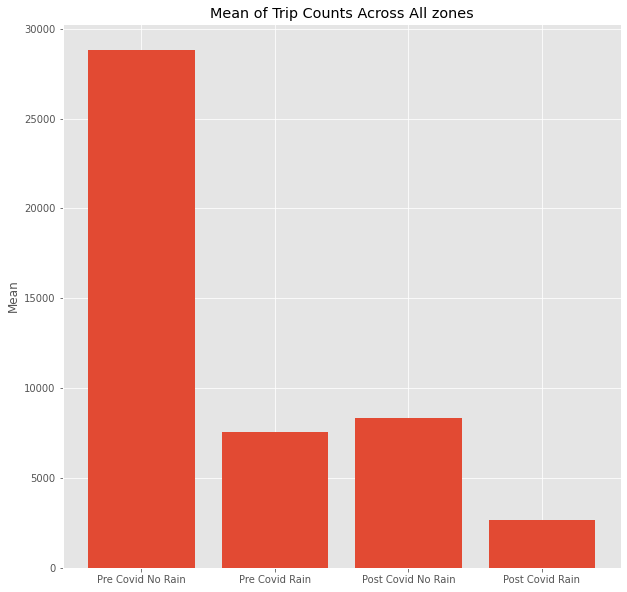

In [501]:
fig, ax = plt.subplots(figsize = (10,10))

precovid_rain_countgroup_zone = precovid_nyc_taxi.loc[(precovid_nyc_taxi["Percipitation (in)"] > 0.1) & (precovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("count")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
precovid_notrain_countgroup_zone = precovid_nyc_taxi.loc[(precovid_nyc_taxi["Percipitation (in)"] <= 0.1) & (precovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("count")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
postcovid_rain_countgroup_zone = postcovid_nyc_taxi.loc[(postcovid_nyc_taxi["Percipitation (in)"] > 0.1) & (postcovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("count")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]
postcovid_notrain_countgroup_zone = postcovid_nyc_taxi.loc[(postcovid_nyc_taxi["Percipitation (in)"] <= 0.1) & (postcovid_nyc_taxi["payment_type"] == 1)].groupby(["PULocationID"], as_index=False).agg("count")[["PULocationID", "tip_amount", "duration", "tip_per_minute"]]

ax.bar(x = ["Pre Covid No Rain", "Pre Covid Rain", "Post Covid No Rain", "Post Covid Rain"], height = [precovid_notrain_countgroup_zone["tip_per_minute"].describe()["mean"], precovid_rain_countgroup_zone["tip_per_minute"].describe()["mean"], postcovid_notrain_countgroup_zone["tip_per_minute"].describe()["mean"], postcovid_rain_countgroup_zone["tip_per_minute"].describe()["mean"]])
ax.set(
       ylabel="Mean",
       title="Mean of Trip Counts Across All zones")

plt.savefig("plots/Mean of Trip Counts Tips Across All zones.png")
plt.show()

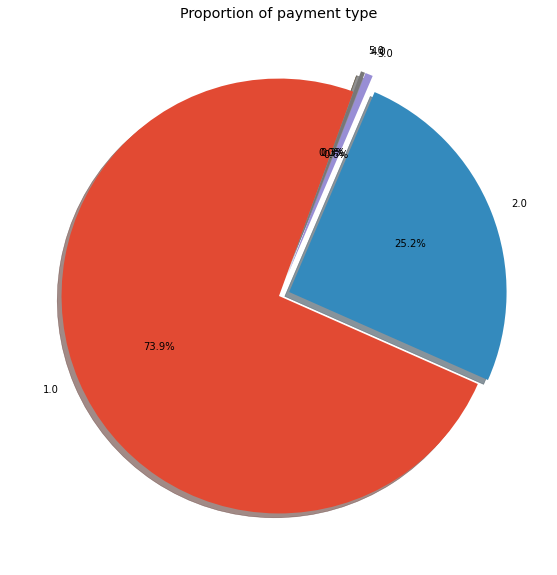

In [505]:
temp = final_df.groupby(["payment_type"], as_index= False).agg("count")
fig, ax = plt.subplots(figsize = (10,10))
ax.pie(temp["fare_amount"], labels = temp["payment_type"], autopct='%1.1f%%', explode = [0,0.05, 0.1,0.1,0.1],
        shadow=True, startangle=70)
ax.set(title = "Proportion of payment type")
plt.savefig("plots/proportion of payment type.png")
plt.show()